# Earthquake Prediction

In [36]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cb
from sklearn import preprocessing, model_selection, linear_model
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix, recall_score

In [37]:
filepath = './data/earthquakes.csv'

In [38]:
df = pd.read_csv(filepath)
df = df.set_index('time')
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.head()

,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
time,,,,,,,,,,,,,,,,,,,,,
2020-07-12 10:31:53.318000+00:00,67.791600,-158.636400,15.00,1.10,ml,NaN,NaN,NaN,0.42,ak,...,2020-08-04T02:49:26.410Z,"85 km NNW of Ambler, Alaska",earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak
2020-07-12 10:38:04.580000+00:00,33.177833,-116.127833,11.36,0.72,ml,35.0,60.0,0.040210,0.19,ci,...,2020-07-13T22:21:26.937Z,"4km N of Ocotillo Wells, CA",earthquake,0.24,0.34,0.158,12.0,reviewed,ci,ci
2020-07-12 10:38:50.280000+00:00,38.816334,-122.813500,3.17,0.91,md,22.0,46.0,0.007542,0.02,nc,...,2020-07-12T11:51:04.930Z,"7km NW of The Geysers, CA",earthquake,0.26,0.50,0.130,3.0,automatic,nc,nc
2020-07-12 10:40:29.962000+00:00,63.047100,-150.433700,107.20,1.10,ml,NaN,NaN,NaN,0.21,ak,...,2020-08-04T02:49:33.285Z,"63 km NNE of Petersville, Alaska",earthquake,NaN,0.50,NaN,NaN,reviewed,ak,ak
2020-07-12 10:50:55.660000+00:00,36.073167,-117.642167,4.75,0.88,ml,13.0,85.0,0.110600,0.14,ci,...,2020-07-12T16:37:38.032Z,"28km E of Coso Junction, CA",earthquake,0.27,2.64,0.189,9.0,reviewed,ci,ci


In [39]:
df.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,35245.000000,35245.000000,35245.000000,35244.000000,28039.000000,29242.000000,24219.000000,35245.000000,24990.000000,35245.000000,26445.000000,27361.000000
mean,37.167296,-108.587333,21.477970,1.663011,23.384821,116.449267,0.816615,0.275335,1.929262,4.240555,0.252210,17.163664
std,19.093452,67.751199,54.360028,1.311471,21.687507,60.421071,2.755243,0.272876,3.300828,389.379273,0.461743,34.172450
min,-65.352200,-179.996400,-3.730000,-1.430000,0.000000,11.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000
25%,33.420500,-149.703200,3.600000,0.800000,10.000000,71.000000,0.025000,0.100000,0.280000,0.470000,0.103000,5.000000
50%,38.151200,-118.777667,8.000000,1.340000,17.000000,102.000000,0.059570,0.160000,0.480000,0.800000,0.160000,9.000000
75%,47.511900,-113.778167,14.560000,2.110000,29.000000,150.000000,0.165750,0.400000,1.090000,1.780000,0.236000,18.000000
max,87.349200,180.000000,647.998000,7.800000,444.000000,355.000000,43.236000,2.460000,26.400000,73091.100000,5.520000,760.000000


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35245 entries, 2020-07-12 10:31:53.318000+00:00 to 2022-10-06 13:10:10.910000+00:00
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   latitude         35245 non-null  float64
 1   longitude        35245 non-null  float64
 2   depth            35245 non-null  float64
 3   mag              35244 non-null  float64
 4   magType          35244 non-null  object 
 5   nst              28039 non-null  float64
 6   gap              29242 non-null  float64
 7   dmin             24219 non-null  float64
 8   rms              35245 non-null  float64
 9   net              35245 non-null  object 
 10  id               35245 non-null  object 
 11  updated          35245 non-null  object 
 12  place            34456 non-null  object 
 13  type             35245 non-null  object 
 14  horizontalError  24990 non-null  float64
 15  depthError       35245 non-null  float64
 1

In [41]:
df.isnull().sum()

latitude               0
longitude              0
depth                  0
mag                    1
magType                1
nst                 7206
gap                 6003
dmin               11026
rms                    0
net                    0
id                     0
updated                0
place                789
type                   0
horizontalError    10255
depthError             0
magError            8800
magNst              7884
status                 0
locationSource         0
magSource              0
dtype: int64

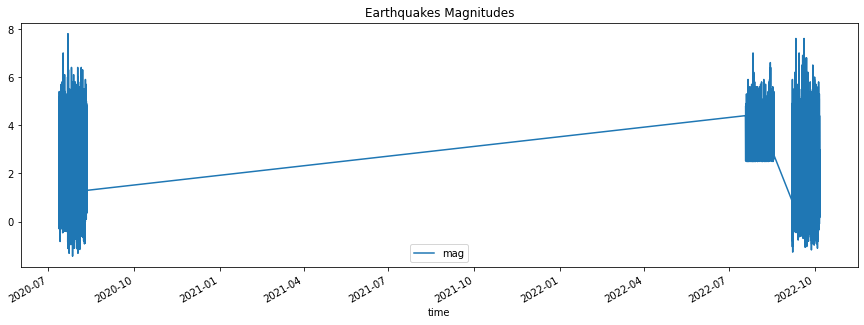

In [42]:
df.plot(figsize=(15, 5), title='Earthquakes Magnitudes', y='mag')
plt.show()

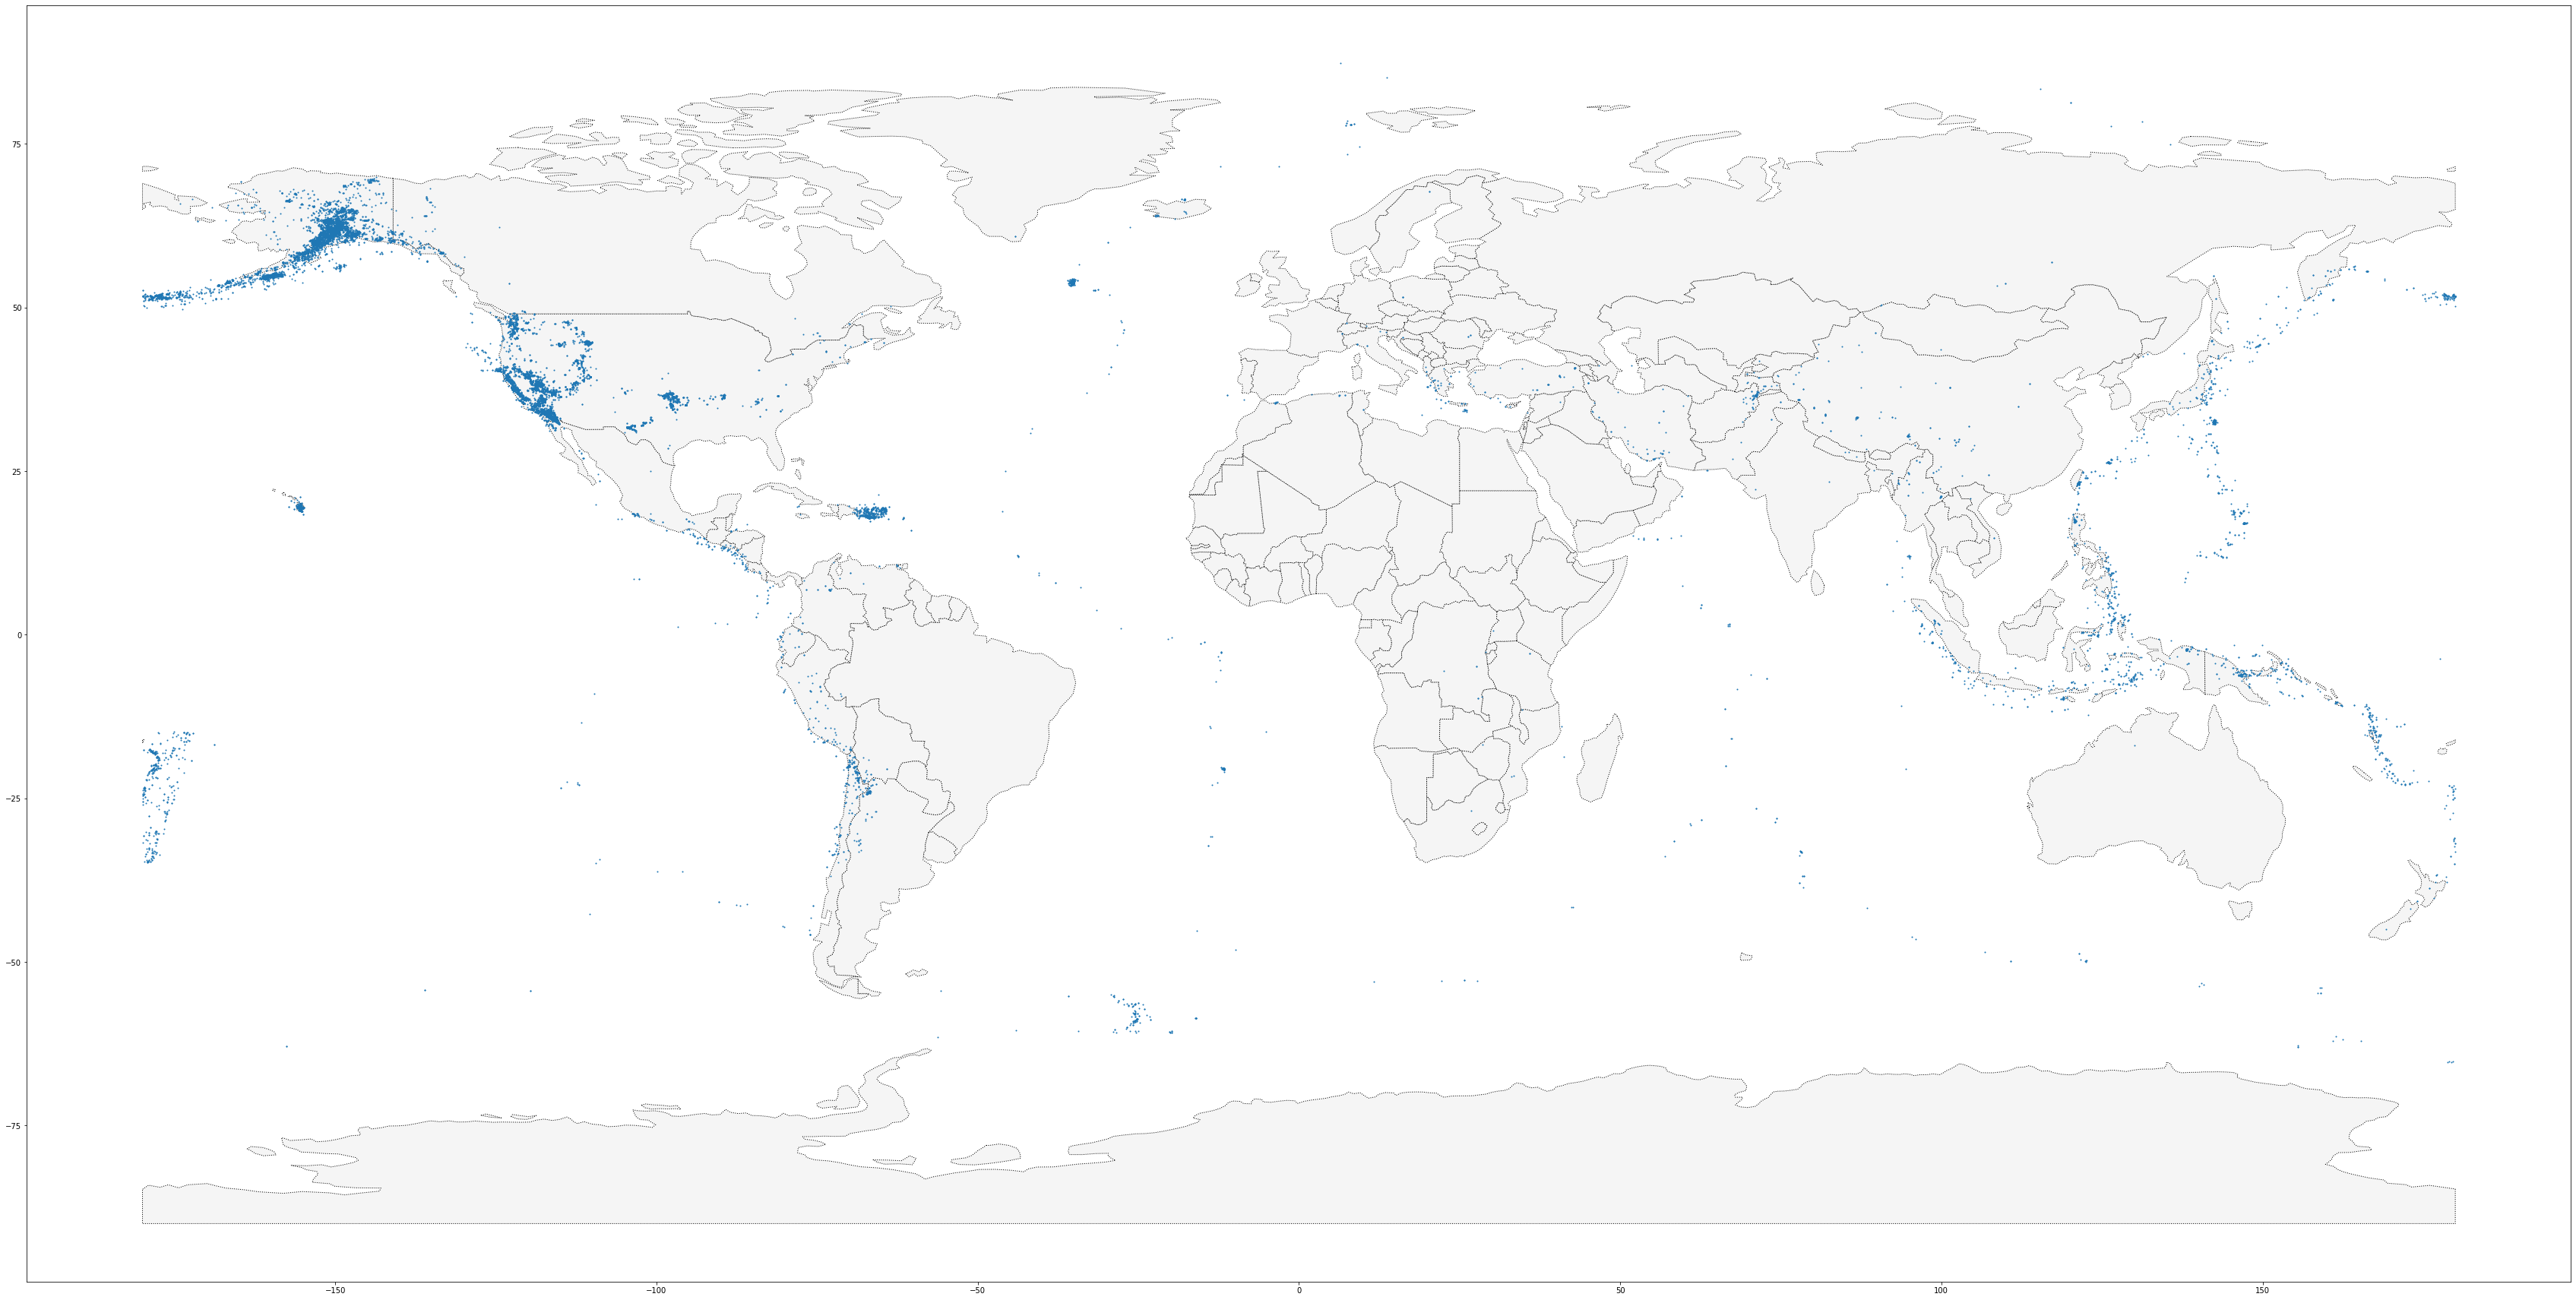

In [43]:
earthquakes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
earthquakes.crs = 'EPSG:4326'

world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)

ax = world.plot(figsize=(60, 60), color='whitesmoke', linestyle=':', edgecolor='black')
earthquakes.to_crs(epsg=4326).plot(markersize=1, ax=ax)
plt.show()

In [44]:
print(f'Min magnitude: {df.mag.min()}')
print(f'Max magnitude: {df.mag.max()}')

Min magnitude: -1.43
Max magnitude: 7.8


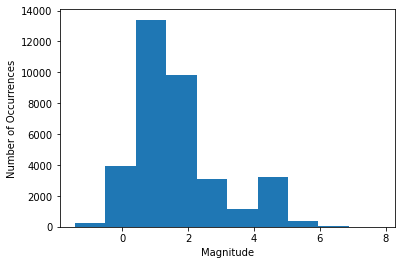

In [45]:
plt.hist(df.mag)
plt.xlabel('Magnitude')
plt.ylabel('Number of Occurrences')
plt.show()

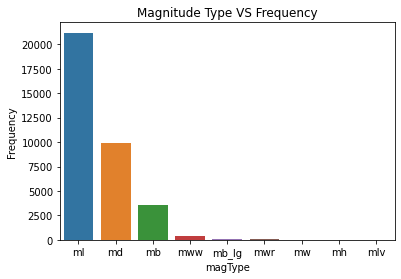

local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)


In [46]:
sns.countplot(data=df, x='magType')
plt.ylabel('Frequency')
plt.title('Magnitude Type VS Frequency')
plt.show()

print('local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)')

In [47]:
df.loc[df.mag >= 8, 'Class'] = 'Disastrous'
df.loc[(df.mag >= 7) & (df.mag < 7.9), 'Class'] = 'Major'
df.loc[(df.mag >= 6) & (df.mag < 6.9), 'Class'] = 'Strong'
df.loc[(df.mag >= 5.5) & (df.mag < 5.9), 'Class'] = 'Moderate'

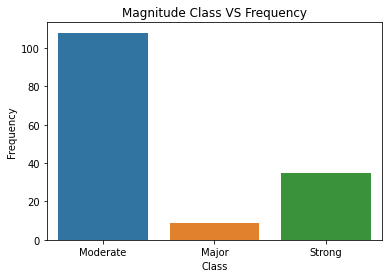

In [48]:
sns.countplot(data=df, x='Class')
plt.ylabel('Frequency')
plt.title('Magnitude Class VS Frequency')
plt.show()

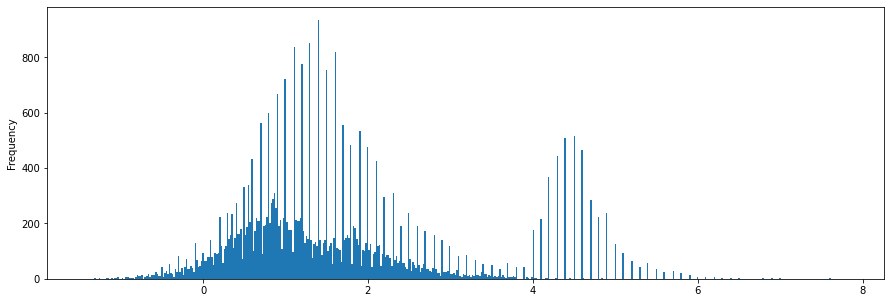

In [49]:
df.mag.plot(kind='hist', bins=500, figsize=(15, 5))
plt.show()

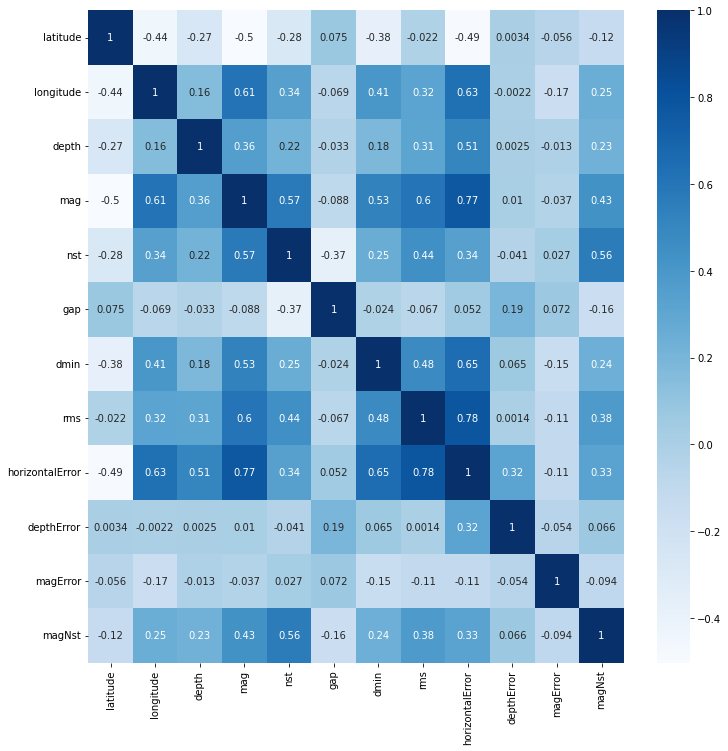

In [50]:
corr_matrix = df.corr() 
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.show()

In [51]:
threshold = 0.9
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
df = df.drop(to_drop, axis=1)

In [52]:
for column in df.columns:
    if df[column].isna().mean() > 0.3:
        df = df.drop(column, axis=1) 

df = df.dropna(axis=0)

In [53]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """Creates time series features based on time series index."""
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

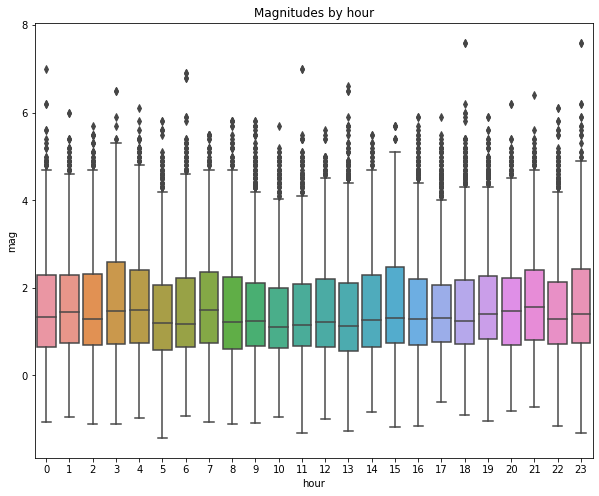

In [54]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='mag')
ax.set_title('Magnitudes by hour')
plt.show()

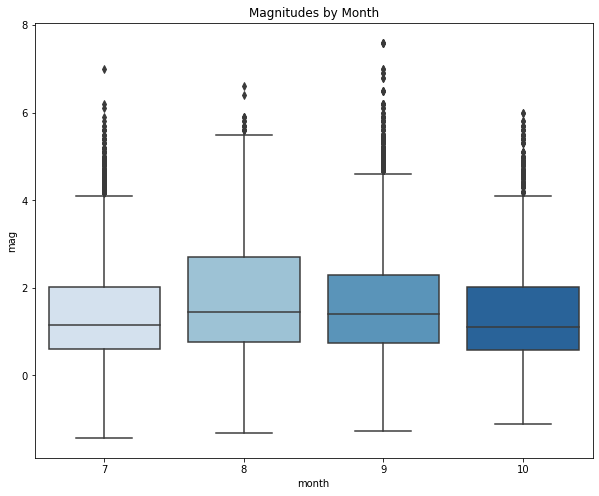

In [55]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='mag', palette='Blues')
ax.set_title('Magnitudes by Month')
plt.show()

In [56]:
def add_lags(df: pd.DataFrame) -> pd.DataFrame:
    df['mag_5d_lag'] = df.mag.shift(5)
    df['mag_10d_lag'] = df.mag.shift(10)
    df['mag_15d_lag'] = df.mag.shift(15)
    df['depth_5d_lag'] = df.depth.shift(5)
    df['depth_10d_lag'] = df.depth.shift(10)
    df['depth_15d_lag'] = df.depth.shift(15)
    return df

df = add_lags(df)

In [57]:
def add_averages(df: pd.DataFrame) -> pd.DataFrame:
    df['mag_5d_avg'] = df.mag.rolling(window=5,center=False).mean() 
    df['mag_10d_avg'] = df.mag.rolling(window=10,center=False).mean() 
    df['mag_15d_avg'] = df.mag.rolling(window=15,center=False).mean() 
    df['depth_5d_avg'] = df.depth.rolling(window=5,center=False).mean() 
    df['depth_10d_avg'] = df.depth.rolling(window=10,center=False).mean() 
    df['depth_15d_avg'] = df.depth.rolling(window=15,center=False).mean() 
    return df

df = add_averages(df)  

In [58]:
features = [
    'dayofyear', 
    'hour', 
    'dayofweek', 
    'month', 
    'year', 
    'mag_5d_lag', 
    'mag_10d_lag', 
    'mag_15d_lag', 
    'mag_5d_avg',
    'mag_10d_avg', 
    'mag_15d_avg',
    'depth_5d_lag',
    'depth_10d_lag',
    'depth_15d_lag',
    'depth_5d_avg',
    'depth_10d_avg',
    'depth_15d_avg',
    'latitude', 
    'longitude'
]
cat_features = ['place']
target = 'mag'

In [59]:
date = '2022-09-23 00:00:00.000000+00:00'

df_train = df.loc[df.index < date]
df_train = df_train[features + cat_features + [target]]

df_test = df.loc[df.index >= date]
df_test = df_test[features + cat_features + [target]]

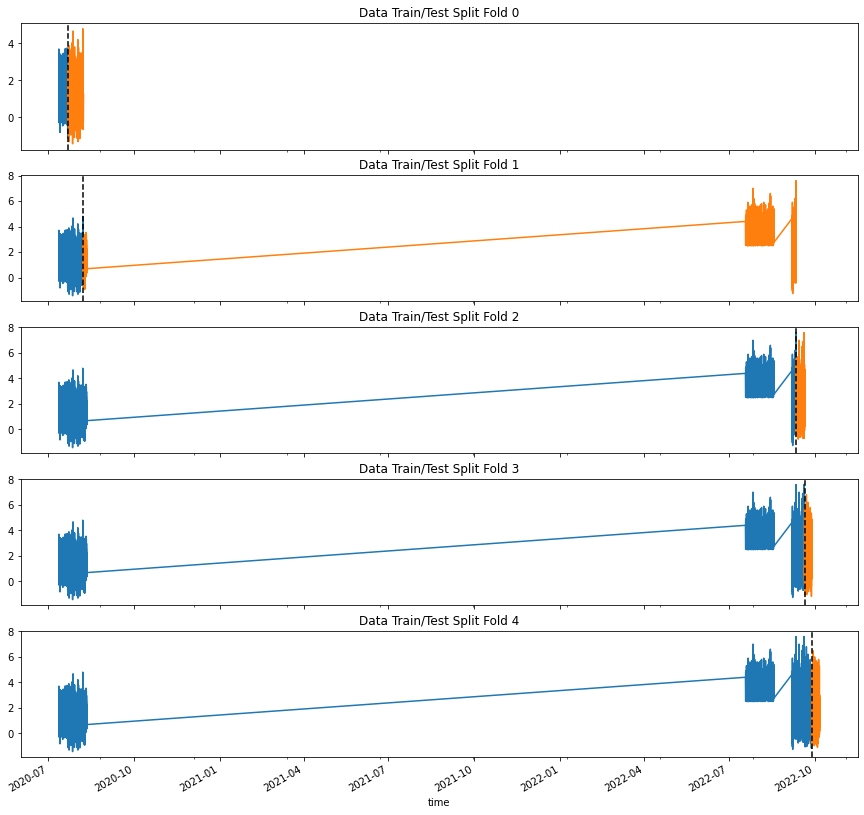

In [60]:
tss = model_selection.TimeSeriesSplit(n_splits=5, test_size=4000, gap=20)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train.mag.plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test.mag.plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

plt.show()

In [61]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    x_train = train[features + cat_features]
    y_train = train[target]

    x_test = test[features + cat_features]
    y_test = test[target]

    model = cb.CatBoostRegressor(early_stopping_rounds=50, cat_features=cat_features)
    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=100)

    y_pred = model.predict(x_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

Learning rate set to 0.057823
0:	learn: 0.7794923	test: 0.7794923	test1: 0.8023804	best: 0.8023804 (0)	total: 4.99ms	remaining: 4.98s
100:	learn: 0.4266603	test: 0.3793496	test1: 0.5248251	best: 0.5248247 (99)	total: 361ms	remaining: 3.21s
200:	learn: 0.3747610	test: 0.3328134	test1: 0.5138474	best: 0.5138271 (199)	total: 738ms	remaining: 2.93s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5136384748
bestIteration = 202

Shrink model to first 203 iterations.
Learning rate set to 0.067892
0:	learn: 0.7819350	test: 0.7819350	test1: 2.0634629	best: 2.0634629 (0)	total: 6.84ms	remaining: 6.84s
100:	learn: 0.4596364	test: 0.4133725	test1: 1.3694775	best: 1.3664960 (97)	total: 504ms	remaining: 4.48s
200:	learn: 0.4229166	test: 0.3856519	test1: 1.2991507	best: 1.2991507 (200)	total: 998ms	remaining: 3.97s
300:	learn: 0.3966301	test: 0.3647174	test1: 1.2860276	best: 1.2827626 (292)	total: 1.58s	remaining: 3.68s
400:	learn: 0.3752250	test: 0.3471397	test1: 1.2631052	best: 

In [62]:
print(f'Score across folds {np.mean(scores)}')
print(f'Fold scores:{scores}')

Score across folds 0.6942
Fold scores:[0.5136384732609552, 1.2532118077062355, 0.5945359727358531, 0.5471420083096162, 0.5627019813196407]


In [63]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    df_train[features + cat_features],
    df_train[target], 
    test_size=0.2, 
    random_state=42,
)

In [64]:
grid = {
    'depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.05, 0.1, 0.01],
    'iterations': [1000],
}

model = cb.CatBoostRegressor(early_stopping_rounds=50, cat_features=cat_features)
grid_search_result = model.grid_search(grid, x_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.0700932	test: 2.0732332	best: 2.0732332 (0)	total: 12.3ms	remaining: 12.3s
1:	learn: 1.9824303	test: 1.9842559	best: 1.9842559 (1)	total: 19.4ms	remaining: 9.69s
2:	learn: 1.9023667	test: 1.9026132	best: 1.9026132 (2)	total: 25.8ms	remaining: 8.57s
3:	learn: 1.8266449	test: 1.8243105	best: 1.8243105 (3)	total: 35.5ms	remaining: 8.83s
4:	learn: 1.7525531	test: 1.7506002	best: 1.7506002 (4)	total: 42.4ms	remaining: 8.44s
5:	learn: 1.6828812	test: 1.6813223	best: 1.6813223 (5)	total: 54.1ms	remaining: 8.96s
6:	learn: 1.6174294	test: 1.6147849	best: 1.6147849 (6)	total: 59ms	remaining: 8.37s
7:	learn: 1.5560340	test: 1.5518701	best: 1.5518701 (7)	total: 64.3ms	remaining: 7.97s
8:	learn: 1.5003563	test: 1.4952055	best: 1.4952055 (8)	total: 68.6ms	remaining: 7.56s
9:	learn: 1.4474872	test: 1.4413769	best: 1.4413769 (9)	total: 71.4ms	remaining: 7.07s
10:	learn: 1.3936741	test: 1.3885013	best: 1.3885013 (10)	total: 73.3ms	remaining: 6.59s
11:	learn: 1.3431087	test: 1.3378611	best: 

In [65]:
grid_search_result['params']

{'depth': 7, 'iterations': 1000, 'learning_rate': 0.1}

In [66]:
prediction = model.predict(x_test)
print(f'Accuracy of Model: {model.score(x_test, y_test)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, prediction)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, prediction))}')

Accuracy of Model: 0.9016711271118223
Mean Absolute Error: 0.3202023723666882
Root Mean Squared Error: 0.4362663195089426


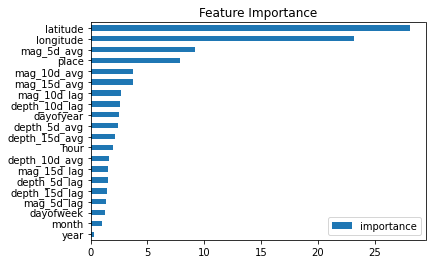

In [67]:
fi = pd.DataFrame(data=model.feature_importances_, index=model.feature_names_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Accuracy of Model: 0.8429897229044357
Mean Absolute Error: 0.42188464090223254
Root Mean Squared Error: 0.5661743750034485


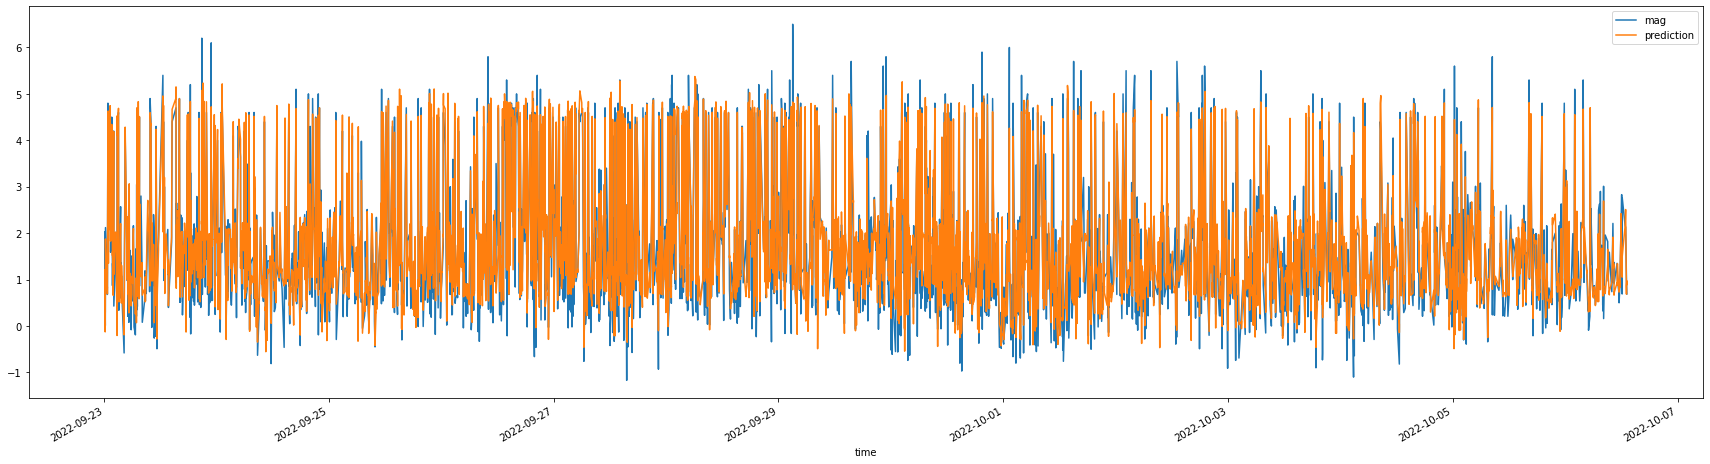

In [68]:
prediction = model.predict(df_test[features + cat_features])
print(f'Accuracy of Model: {model.score(df_test[features + cat_features], df_test[target])}')
print(f'Mean Absolute Error: {mean_absolute_error(df_test[target], prediction)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(df_test[target], prediction))}')

df_plot = pd.DataFrame({'mag': df_test[target], 'prediction': prediction}, index=df_test.index)
df_plot = df_plot[::-1]
df_plot.plot(figsize=(30, 8))
plt.show()

In [70]:
# model.save_model('../app/server/app/ml/model')